In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_excel('/content/drive/MyDrive/LCF_Internal/Renewable_Model/EDA Approach-1/XGBoost Implementation/xgboost_v7/V7_final_EDA.xlsx')

In [4]:
data.shape

(3127, 29)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3127 entries, 0 to 3126
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   OpportunityID                          3127 non-null   object 
 1   Renewal_PreviousPace                   3127 non-null   float64
 2   Renewal_PreviousPaidPercentageOfRTR    3127 non-null   float64
 3   Renewal_CountPreviousDeals             3127 non-null   int64  
 4   Renewal_PreviousCountBounces           3127 non-null   int64  
 5   Renewal_PreviousPosition               3127 non-null   int64  
 6   Renewal_PreviousHBwLCF                 3127 non-null   float64
 7   Renewal_PreviousAvgMonthRevenue        3127 non-null   float64
 8   Renewal_PreviousAvgDailyBalance        3127 non-null   float64
 9   Renewal_TwoWeekBounces                 3127 non-null   int64  
 10  NumberOfBankStatements                 3127 non-null   int64  
 11  Bank

In [6]:
def plot_distribution(df_feature):
  plt.figure(figsize=(20,10))
  plt.subplot(2,2,1)
  sns.distplot(df_feature)
  plt.subplot(2,2,2)
  sns.boxplot(df_feature)
  plt.show()

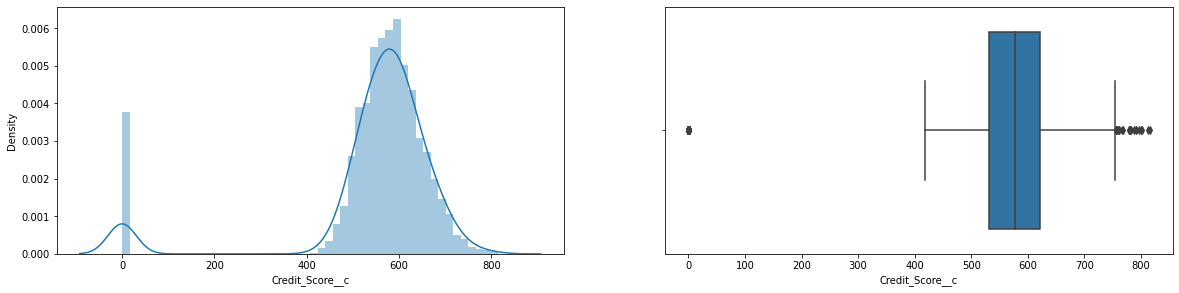

In [7]:
plot_distribution(data["Credit_Score__c"])

In [8]:
data[(data['Credit_Score__c']==0) | (data["Credit_Score__c"] == 1)]['WriteOff_YN']

7       0
15      0
17      1
18      1
23      0
       ..
3078    0
3080    1
3081    1
3084    0
3087    0
Name: WriteOff_YN, Length: 192, dtype: int64

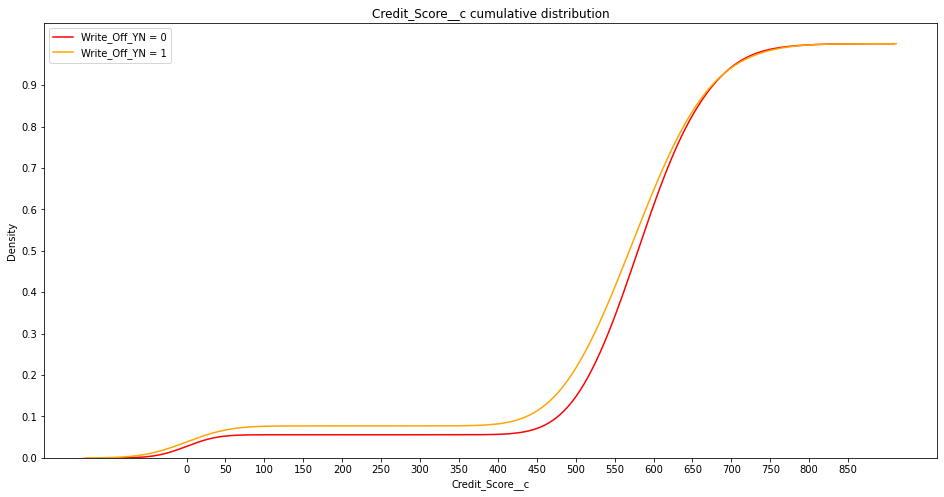

In [9]:
plt.figure(figsize = (16,8))

sns.kdeplot(data = data[data['WriteOff_YN']==0]['Credit_Score__c'], cumulative = True, label = "Write_Off_YN = 0",color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['Credit_Score__c'], cumulative = True, label = "Write_Off_YN = 1",color = 'orange')
plt.xticks(np.arange(0,900,50))
plt.yticks(np.arange(0,1,0.1))
plt.title('Credit_Score__c cumulative distribution')
plt.legend()

In [10]:
# features from credit_score__c
f1_credit_score, f2_credit_score, f3_credit_score = [], [], []
for i in data["Credit_Score__c"]:
  if i >=400 and i <500:
    f1_credit_score.append(1)
    f2_credit_score.append(0)
    f3_credit_score.append(0)
  elif i >=500 and i <600:
    f1_credit_score.append(0)
    f2_credit_score.append(1)
    f3_credit_score.append(0)
  else:
    f1_credit_score.append(0)
    f2_credit_score.append(0)
    f3_credit_score.append(1)    

In [11]:
print("Len of f1", len(f1_credit_score))
print("Len of f2", len(f2_credit_score))
print("Len of f3", len(f3_credit_score))

Len of f1 3127
Len of f2 3127
Len of f3 3127


In [12]:
data["f1_credit_score"] = f1_credit_score
data["f2_credit_score"] = f2_credit_score
data["f3_credit_score"] = f3_credit_score

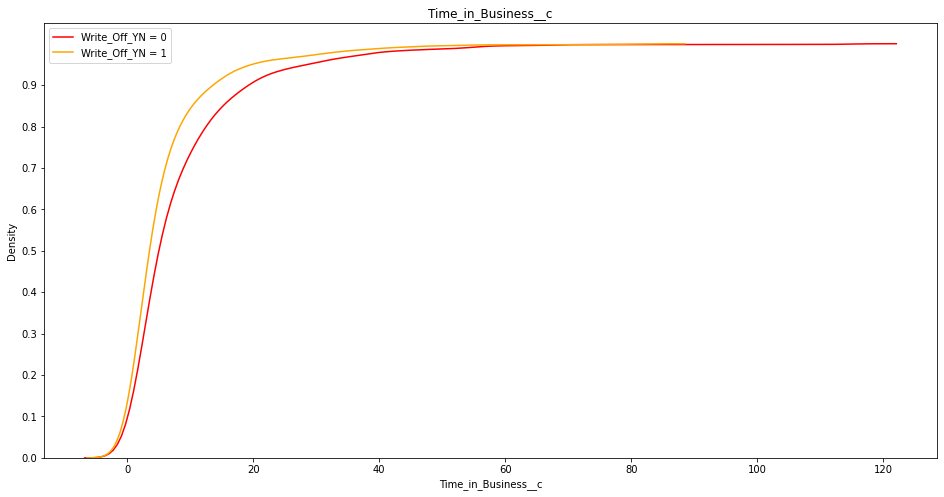

In [13]:
plt.figure(figsize = (16,8))
plt.title('Time_in_Business__c')
sns.kdeplot(data = data[data['WriteOff_YN']==0]['Time_in_Business__c'], cumulative = True, label = "Write_Off_YN = 0",color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['Time_in_Business__c'], cumulative = True, label = "Write_Off_YN = 1",color = 'orange')
#plt.xticks(np.arange(0,900,50))
plt.yticks(np.arange(0,1,0.1))
plt.legend()

In [14]:
data[data["Time_in_Business__c"] < 0]["Time_in_Business__c"]

Series([], Name: Time_in_Business__c, dtype: float64)

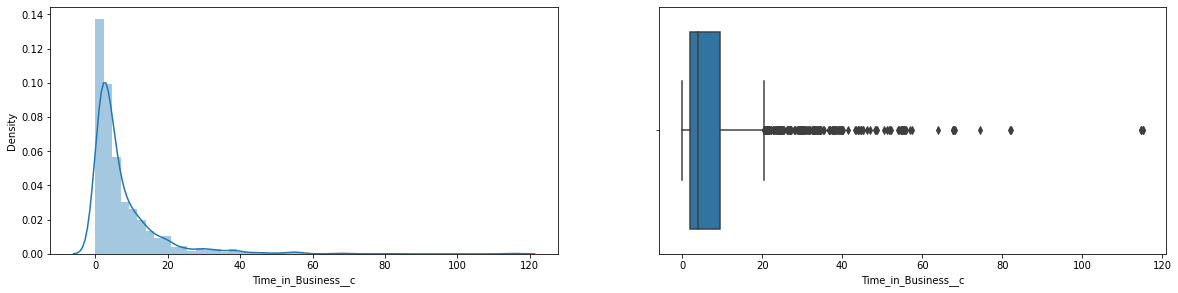

In [15]:
plot_distribution(data["Time_in_Business__c"])

In [16]:
f1_time_business, f2_time_business, f3_time_business = [], [], []
for i in data["Time_in_Business__c"]:
  if i < 20:
    f1_time_business.append(1)
    f2_time_business.append(0)
    f3_time_business.append(0)
  elif i >=20 and i <=40:
    f1_time_business.append(0)
    f2_time_business.append(1)
    f3_time_business.append(0)
  else:
    f1_time_business.append(0)
    f2_time_business.append(0)
    f3_time_business.append(1)
    

In [17]:
data["f1_time_in_business"] = f1_time_business
data["f2_time_in_business"] = f2_time_business
data["f3_time_business"] = f3_time_business

In [18]:
data['BankStatement_MA_NumReturnItems'].describe()

count    3127.000000
mean        1.046765
std         3.412470
min         0.000000
25%         0.000000
50%         0.000000
75%         0.500000
max        98.333333
Name: BankStatement_MA_NumReturnItems, dtype: float64

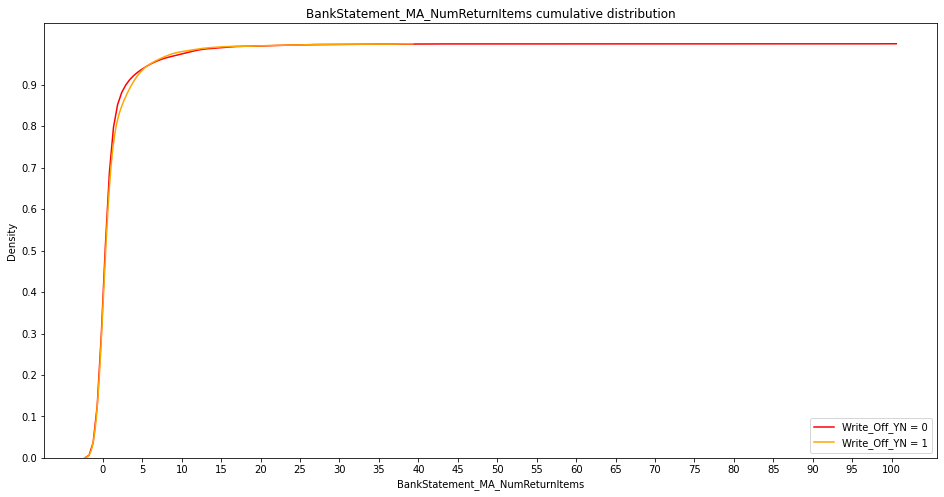

In [19]:
plt.figure(figsize = (16,8))
plt.title('BankStatement_MA_NumReturnItems cumulative distribution')
sns.kdeplot(data = data[data['WriteOff_YN']==0]['BankStatement_MA_NumReturnItems'], cumulative = True, label = "Write_Off_YN = 0",color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['BankStatement_MA_NumReturnItems'], cumulative = True, label = "Write_Off_YN = 1",color = 'orange')
plt.xticks(np.arange(0,101,5))
plt.yticks(np.arange(0,1,0.1))
plt.legend()

In [20]:
data['Renewal_TwoWeekBounces'].value_counts()

0    3030
1      79
2      16
4       1
3       1
Name: Renewal_TwoWeekBounces, dtype: int64

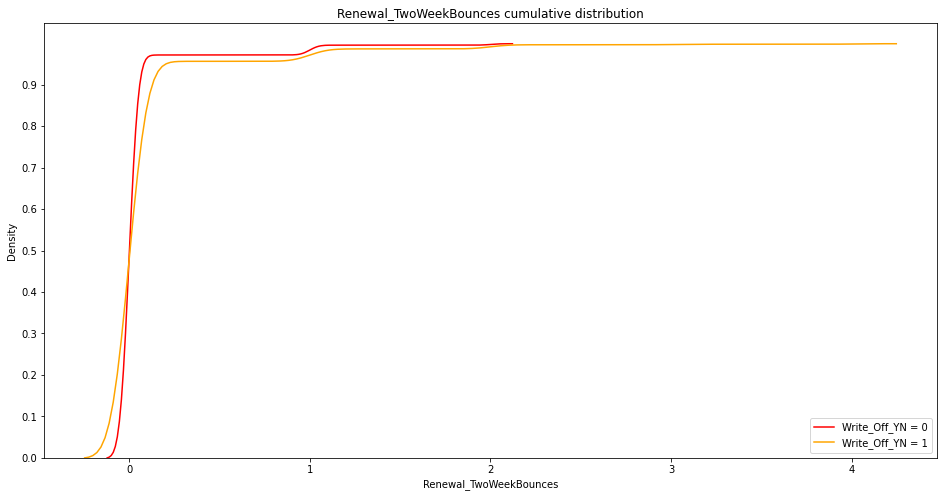

In [21]:
plt.figure(figsize = (16,8))
plt.title('Renewal_TwoWeekBounces cumulative distribution')
sns.kdeplot(data = data[data['WriteOff_YN']==0]['Renewal_TwoWeekBounces'], cumulative = True, label = "Write_Off_YN = 0",color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['Renewal_TwoWeekBounces'], cumulative = True, label = "Write_Off_YN = 1",color = 'orange')
#plt.xticks(np.arange(0,101,5))
plt.yticks(np.arange(0,1,0.1))
plt.legend()

In [22]:
data['NumberOfBankStatements'].value_counts()

3    1971
2     574
1     472
0      85
4      21
5       3
6       1
Name: NumberOfBankStatements, dtype: int64

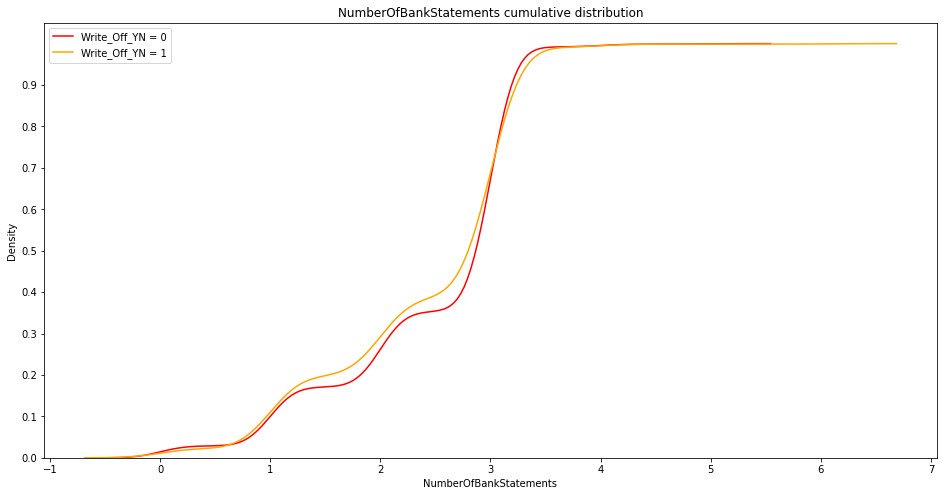

In [23]:
plt.figure(figsize = (16,8))
plt.title('NumberOfBankStatements cumulative distribution')
sns.kdeplot(data = data[data['WriteOff_YN']==0]['NumberOfBankStatements'], cumulative = True, label = "Write_Off_YN = 0",color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['NumberOfBankStatements'], cumulative = True, label = "Write_Off_YN = 1",color = 'orange')
#plt.xticks(np.arange(0,101,5))
plt.yticks(np.arange(0,1,0.1))
plt.legend()

In [24]:
f1_no_bank_stat, f2_no_bank_stat, f3_no_bank_stat = [], [], []
for i in data["NumberOfBankStatements"]:
  if i >= 1.4 and i <2:
    f1_no_bank_stat.append(1)
    f2_no_bank_stat.append(0)
    f3_no_bank_stat.append(0)
  elif i >=2 and i <=3:
    f1_no_bank_stat.append(0)
    f2_no_bank_stat.append(1)
    f3_no_bank_stat.append(0)
  else:
    f1_no_bank_stat.append(0)
    f2_no_bank_stat.append(0)
    f3_no_bank_stat.append(1)


In [25]:
data["f1_NumberOfBankStat"] = f1_no_bank_stat
data["f2_NumberOfBankStat"] = f2_no_bank_stat
data["f3_NumberOfBankStat"] = f3_no_bank_stat

In [26]:
data[data['Renewal_PreviousPace']< 50][['Renewal_PreviousPace', 'WriteOff_YN']]

,Renewal_PreviousPace,WriteOff_YN


In [27]:
# if we arrange Renewal_Precious_Pace in ascending order - it means 99.156 values are under quantile (0.10)
data['Renewal_PreviousPace'].quantile(0.10)

100.0

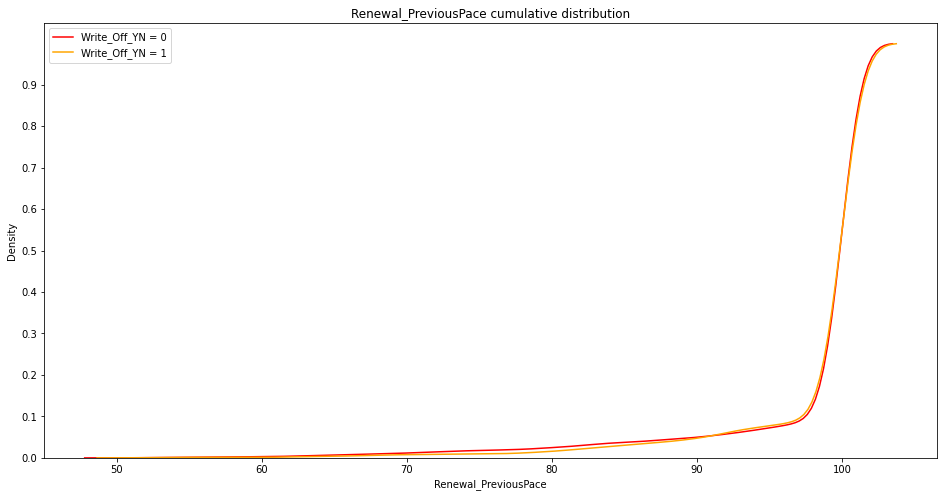

In [28]:
plt.figure(figsize = (16,8))
plt.title('Renewal_PreviousPace cumulative distribution')
sns.kdeplot(data = data[data['WriteOff_YN']==0]['Renewal_PreviousPace'], cumulative = True, label = "Write_Off_YN = 0",color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['Renewal_PreviousPace'], cumulative = True, label = "Write_Off_YN = 1",color = 'orange')
#plt.xticks(np.arange(0,101,5))
plt.yticks(np.arange(0,1,0.1))
plt.legend()

In [29]:
data['Renewal_PreviousPaidPercentageOfRTR'].value_counts()

0.62    679
0.52    119
0.53    117
0.51    104
0.60     99
       ... 
0.19      1
1.51      1
1.57      1
1.42      1
1.52      1
Name: Renewal_PreviousPaidPercentageOfRTR, Length: 145, dtype: int64

In [30]:
data['Renewal_PreviousPaidPercentageOfRTR'].unique()
# What do the values greater than 1 signify?

array([0.8 , 0.66, 0.77, 0.62, 1.11, 0.97, 0.63, 0.82, 0.88, 0.13, 0.33,
       0.75, 0.6 , 0.55, 0.94, 1.16, 0.61, 0.93, 0.84, 0.51, 1.5 , 0.58,
       0.65, 0.7 , 0.52, 0.64, 1.04, 1.25, 0.85, 1.  , 0.76, 0.57, 0.53,
       0.74, 0.54, 0.99, 0.71, 0.56, 0.69, 0.9 , 1.72, 0.72, 1.03, 0.73,
       0.67, 0.4 , 0.44, 0.47, 0.5 , 1.41, 1.18, 0.78, 0.83, 1.1 , 1.32,
       0.95, 0.46, 1.02, 1.15, 1.01, 1.28, 0.48, 1.69, 0.68, 0.92, 1.3 ,
       0.23, 0.49, 0.27, 0.87, 1.48, 1.77, 0.98, 0.59, 1.08, 0.96, 1.65,
       1.13, 1.14, 0.91, 0.86, 0.81, 0.42, 1.17, 1.2 , 0.08, 1.22, 1.37,
       0.29, 0.36, 0.89, 1.4 , 0.34, 0.43, 1.33, 0.17, 0.39, 0.31, 1.07,
       0.79, 1.24, 0.28, 0.14, 1.38, 0.19, 1.51, 1.57, 1.45, 2.15, 0.32,
       1.93, 0.41, 1.42, 0.25, 1.09, 0.26, 1.31, 0.3 , 0.21, 0.05, 0.18,
       0.24, 0.1 , 0.45, 1.05, 1.06, 0.16, 0.37, 1.27, 0.11, 0.22, 1.29,
       0.35, 1.12, 1.71, 0.  , 0.12, 1.34, 0.2 , 0.38, 1.76, 0.15, 1.39,
       1.36, 1.52])

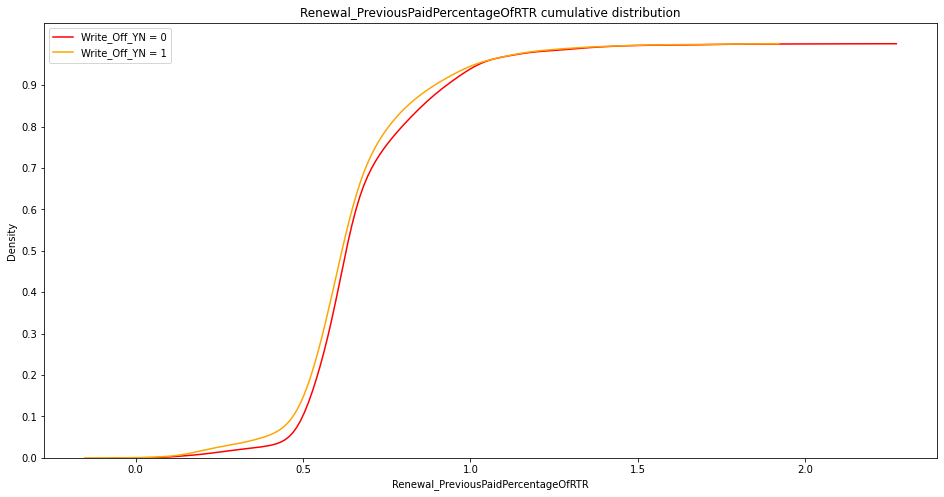

In [31]:
plt.figure(figsize = (16,8))
plt.title('Renewal_PreviousPaidPercentageOfRTR cumulative distribution')
sns.kdeplot(data = data[data['WriteOff_YN']==0]['Renewal_PreviousPaidPercentageOfRTR'], cumulative = True, label = "Write_Off_YN = 0",color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['Renewal_PreviousPaidPercentageOfRTR'], cumulative = True, label = "Write_Off_YN = 1",color = 'orange')
#plt.xticks(np.arange(0,101,5))
plt.yticks(np.arange(0,1,0.1))
plt.legend()

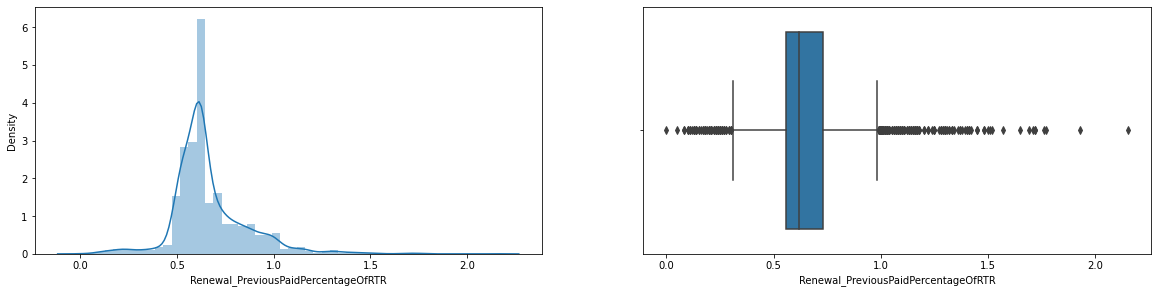

In [32]:
plot_distribution(data['Renewal_PreviousPaidPercentageOfRTR'])

In [33]:
data['Renewal_CountPreviousDeals'].describe()

count    3127.000000
mean        2.185801
std         1.700838
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        14.000000
Name: Renewal_CountPreviousDeals, dtype: float64

In [34]:
data['Renewal_CountPreviousDeals'].value_counts()

1     1515
2      730
3      372
4      199
5      136
6       76
7       45
8       22
9       13
10      11
11       5
13       1
12       1
14       1
Name: Renewal_CountPreviousDeals, dtype: int64

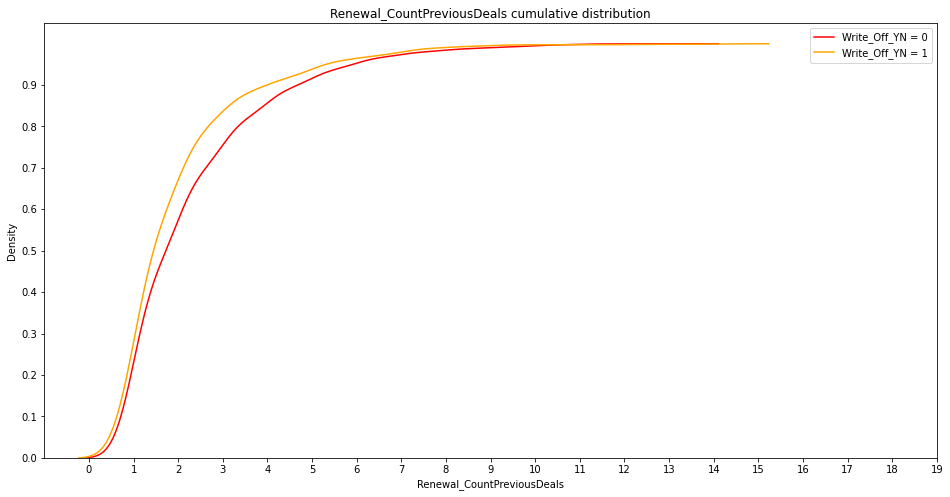

In [35]:
plt.figure(figsize = (16,8))
plt.title('Renewal_CountPreviousDeals cumulative distribution')
sns.kdeplot(data = data[data['WriteOff_YN']==0]['Renewal_CountPreviousDeals'], cumulative = True, label = "Write_Off_YN = 0",color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['Renewal_CountPreviousDeals'], cumulative = True, label = "Write_Off_YN = 1",color = 'orange')
plt.xticks(np.arange(0,20,1))
plt.yticks(np.arange(0,1,0.1))
plt.legend()

In [36]:
f1_ren_count_prev_deal, f3_ren_count_prev_deal, f2_ren_count_prev_deal = [], [], []
for i in data["Renewal_CountPreviousDeals"]:
  if i >= 0 and i <3:
    f1_ren_count_prev_deal.append(1)
    f2_ren_count_prev_deal.append(0)
    f3_ren_count_prev_deal.append(0)
  elif i >=3 and i <=6:
    f1_ren_count_prev_deal.append(0)
    f2_ren_count_prev_deal.append(1)
    f3_ren_count_prev_deal.append(0)
  else:
    f1_ren_count_prev_deal.append(0)
    f2_ren_count_prev_deal.append(0)
    f3_ren_count_prev_deal.append(1)


In [37]:
data["f1_Renewal_CountPreviousDeals"] = f1_ren_count_prev_deal
data["f2_Renewal_CountPreviousDeals"] = f2_ren_count_prev_deal
data["f3_Renewal_CountPreviousDeals"] = f3_ren_count_prev_deal

Analyse Renewal_PreviousCountBounces

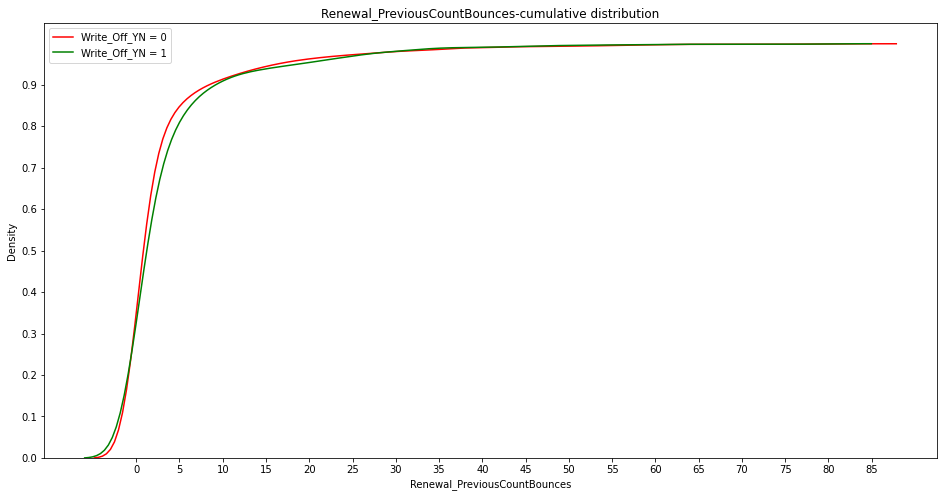

In [39]:
plt.figure(figsize = (16,8))

sns.kdeplot(data = data[data['WriteOff_YN']==0]['Renewal_PreviousCountBounces'], cumulative = True, label = "Write_Off_YN = 0", color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['Renewal_PreviousCountBounces'], cumulative = True, label = "Write_Off_YN = 1", color = 'green')

plt.xticks(np.arange(0,90,5))
plt.yticks(np.arange(0,1,0.1))
plt.title('Renewal_PreviousCountBounces-cumulative distribution')
plt.legend()

In [46]:
f1_ren_count_prev_bounces, f3_ren_count_prev_bounces, f2_ren_count_prev_bounces = [], [], []
for i in data["Renewal_PreviousCountBounces"]:
  if i >= 0 and i <5:
    f1_ren_count_prev_bounces.append(1)
    f2_ren_count_prev_bounces.append(0)
    f3_ren_count_prev_bounces.append(0)
  elif i >=5 and i <=10:
    f1_ren_count_prev_bounces.append(0)
    f2_ren_count_prev_bounces.append(1)
    f3_ren_count_prev_bounces.append(0)
  else:
    f1_ren_count_prev_bounces.append(0)
    f2_ren_count_prev_bounces.append(0)
    f3_ren_count_prev_bounces.append(1)

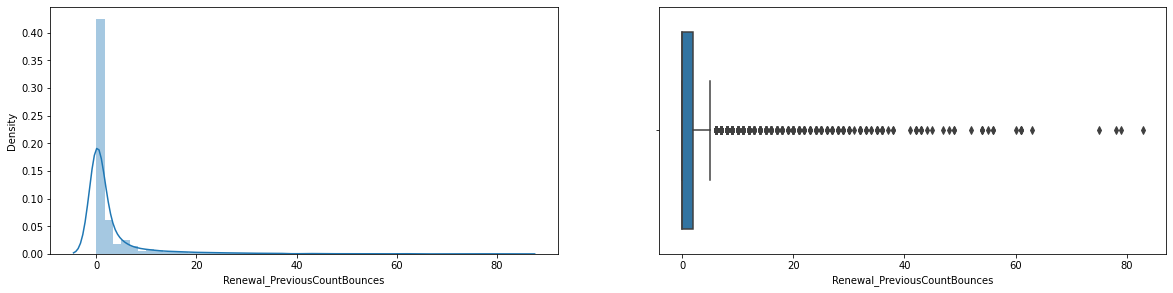

In [47]:
plot_distribution(data["Renewal_PreviousCountBounces"])

In [48]:
data["f1_Renewal_PreviousCountBounces"] = f1_ren_count_prev_bounces
data["f2_Renewal_PreviousCountBounces"] = f2_ren_count_prev_bounces
data["f3_Renewal_PreviousCountBounces"] = f3_ren_count_prev_bounces

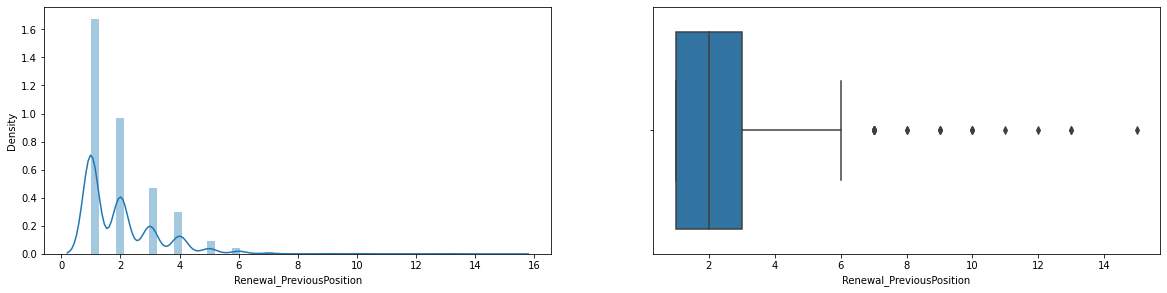

In [49]:
plot_distribution(data["Renewal_PreviousPosition"])

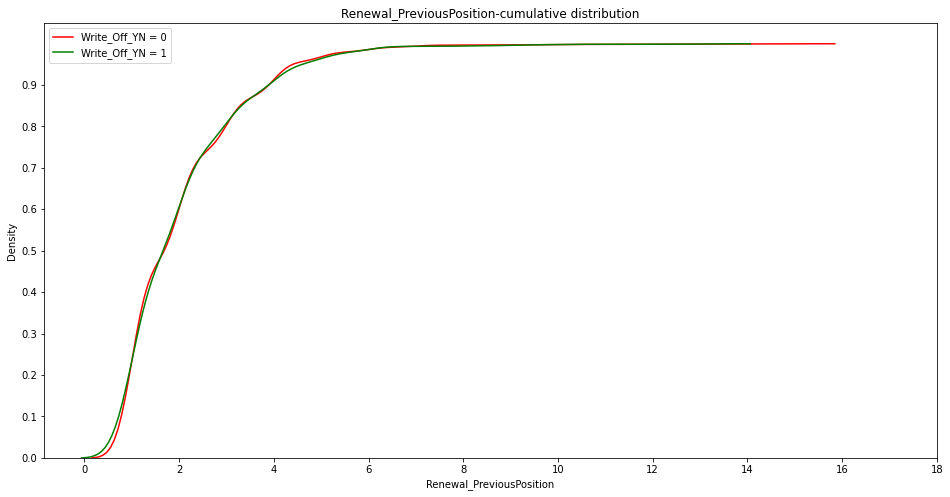

In [50]:
plt.figure(figsize = (16,8))

sns.kdeplot(data = data[data['WriteOff_YN']==0]['Renewal_PreviousPosition'], cumulative = True, label = "Write_Off_YN = 0", color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['Renewal_PreviousPosition'], cumulative = True, label = "Write_Off_YN = 1", color = 'green')

plt.xticks(np.arange(0,20,2))
plt.yticks(np.arange(0,1,0.1))
plt.title('Renewal_PreviousPosition-cumulative distribution')
plt.legend()

In [51]:
data["Renewal_PreviousPosition"].value_counts()

1     1468
2      845
3      410
4      263
5       78
6       39
7       11
9        3
10       3
8        2
13       2
15       1
12       1
11       1
Name: Renewal_PreviousPosition, dtype: int64

Analysing - AvgMonthRevenue 

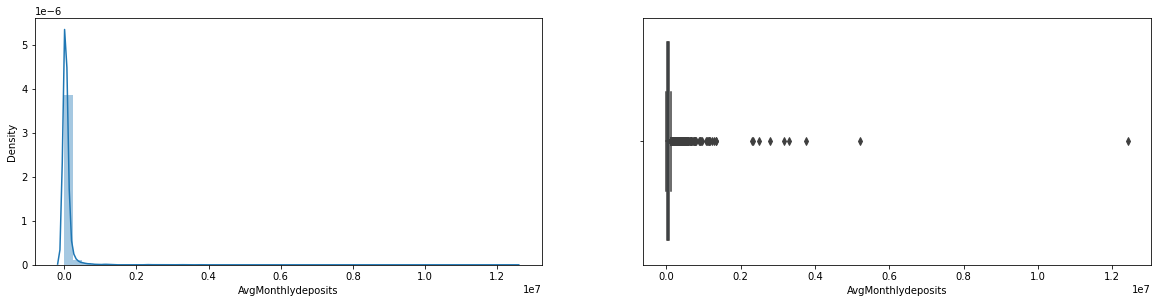

In [52]:
plot_distribution(data["AvgMonthlydeposits"])

In [53]:
data["AvgMonthlydeposits"].isnull().sum()/len(data)*100

0.0

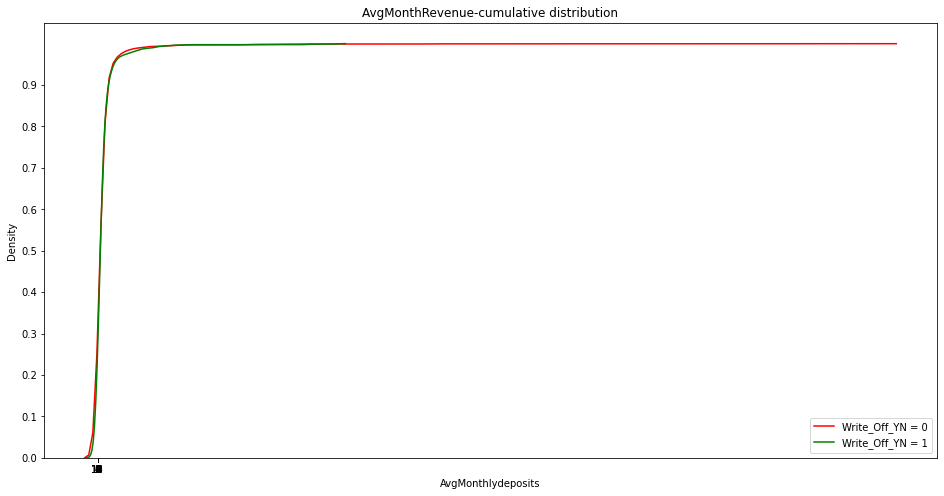

In [54]:
plt.figure(figsize = (16,8))

sns.kdeplot(data = data[data['WriteOff_YN']==0]['AvgMonthlydeposits'], cumulative = True, label = "Write_Off_YN = 0", color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['AvgMonthlydeposits'], cumulative = True, label = "Write_Off_YN = 1", color = 'green')

plt.xticks(np.arange(0,20,2))
plt.yticks(np.arange(0,1,0.1))
plt.title('AvgMonthRevenue-cumulative distribution')
plt.legend()

In [55]:
data["AvgMonthlydeposits"].value_counts()

28046.073333     83
26512.000000      2
13669.000000      2
110737.495000     1
32245.570000      1
                 ..
26127.420000      1
28453.933333      1
19958.000000      1
11994.153333      1
8761.645000       1
Name: AvgMonthlydeposits, Length: 3043, dtype: int64

In [56]:
data["AvgMonthlydeposits"].describe()

count    3.127000e+03
mean     7.203567e+04
std      2.966524e+05
min     -3.078493e+03
25%      1.601977e+04
50%      2.804607e+04
75%      5.603237e+04
max      1.241704e+07
Name: AvgMonthlydeposits, dtype: float64

In [57]:
data[data["AvgMonthlydeposits"]<0]["AvgMonthlydeposits"]

718   -3078.493333
Name: AvgMonthlydeposits, dtype: float64

Analysing - BankStatement_MA_OverdraftDays 

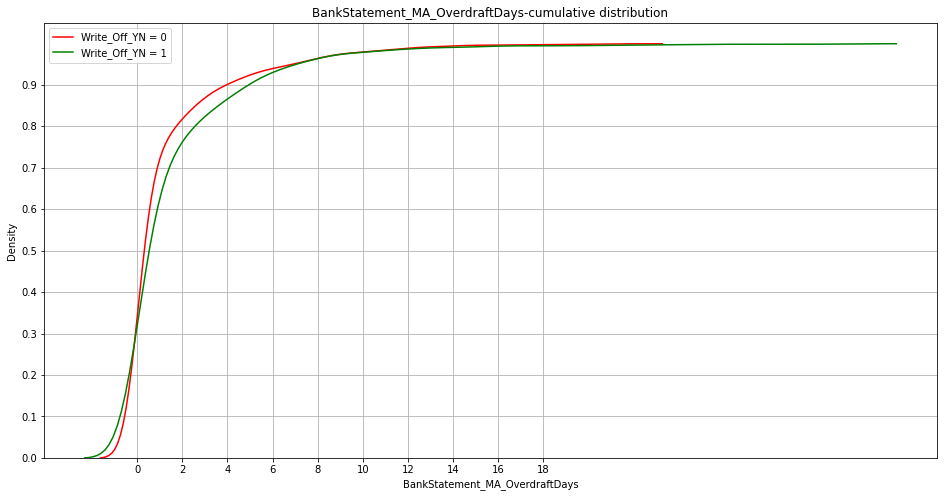

In [58]:
plt.figure(figsize = (16,8))

sns.kdeplot(data = data[data['WriteOff_YN']==0]['BankStatement_MA_OverdraftDays'], cumulative = True, label = "Write_Off_YN = 0", color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['BankStatement_MA_OverdraftDays'], cumulative = True, label = "Write_Off_YN = 1", color = 'green')

plt.xticks(np.arange(0,20,2))
plt.yticks(np.arange(0,1,0.1))
plt.title('BankStatement_MA_OverdraftDays-cumulative distribution')
plt.grid()
plt.legend()

In [59]:
f1_BankStatement_MA_OverdraftDays, f3_BankStatement_MA_OverdraftDays, f2_BankStatement_MA_OverdraftDays = [], [], []
for i in data["BankStatement_MA_OverdraftDays"]:
  if i >= 0 and i <3:
    f1_BankStatement_MA_OverdraftDays.append(1)
    f2_BankStatement_MA_OverdraftDays.append(0)
    f3_BankStatement_MA_OverdraftDays.append(0)
  elif i >=3 and i <=6:
    f1_BankStatement_MA_OverdraftDays.append(0)
    f2_BankStatement_MA_OverdraftDays.append(1)
    f3_BankStatement_MA_OverdraftDays.append(0)
  else:
    f1_BankStatement_MA_OverdraftDays.append(0)
    f2_BankStatement_MA_OverdraftDays.append(0)
    f3_BankStatement_MA_OverdraftDays.append(1)

In [60]:
data["f1_BankStatement_MA_OverdraftDays"] = f1_BankStatement_MA_OverdraftDays
data["f2_BankStatement_MA_OverdraftDays"] = f2_BankStatement_MA_OverdraftDays
data["f3_BankStatement_MA_OverdraftDays"] = f3_BankStatement_MA_OverdraftDays

In [61]:
data.columns

Index(['OpportunityID', 'Renewal_PreviousPace',
       'Renewal_PreviousPaidPercentageOfRTR', 'Renewal_CountPreviousDeals',
       'Renewal_PreviousCountBounces', 'Renewal_PreviousPosition',
       'Renewal_PreviousHBwLCF', 'Renewal_PreviousAvgMonthRevenue',
       'Renewal_PreviousAvgDailyBalance', 'Renewal_TwoWeekBounces',
       'NumberOfBankStatements', 'BankStatement_MA_OverdraftDays',
       'BankStatement_MA_NumReturnItems', 'Credit_Score__c',
       'Time_in_Business__c', 'HB_with_LCF_Payment__c', 'AvgMonthlydeposits',
       'AvgDailybalance', 'FundedAmount', 'Paybackamount', 'WriteOff_YN',
       'FundedWriteOffAmount_Gross', 'WOGross_AdvanceBalance', 'NetWO',
       'Avg_ReturnItemdays', 'LatestMonth_ReturnItemDays',
       'PctChangeInReveune', 'PctAvgDailybalance2AvgMonthlyDeposits',
       'Is_this_Business_home_based__c_Yes', 'f1_credit_score',
       'f2_credit_score', 'f3_credit_score', 'f1_time_in_business',
       'f2_time_in_business', 'f3_time_business', 'f1_Number

Analysing renewable previous pace

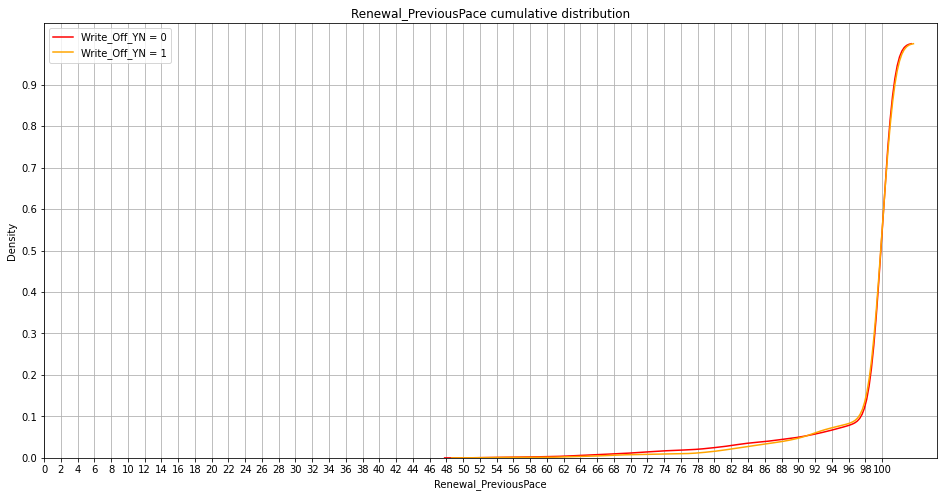

In [62]:
plt.figure(figsize = (16,8))
plt.title('Renewal_PreviousPace cumulative distribution')
sns.kdeplot(data = data[data['WriteOff_YN']==0]['Renewal_PreviousPace'], cumulative = True, label = "Write_Off_YN = 0",color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['Renewal_PreviousPace'], cumulative = True, label = "Write_Off_YN = 1",color = 'orange')
plt.xticks(np.arange(0,101,2))
plt.grid()
plt.yticks(np.arange(0,1,0.1))
plt.legend()

In [63]:
data.shape

(3127, 47)

In [64]:
data.columns

Index(['OpportunityID', 'Renewal_PreviousPace',
       'Renewal_PreviousPaidPercentageOfRTR', 'Renewal_CountPreviousDeals',
       'Renewal_PreviousCountBounces', 'Renewal_PreviousPosition',
       'Renewal_PreviousHBwLCF', 'Renewal_PreviousAvgMonthRevenue',
       'Renewal_PreviousAvgDailyBalance', 'Renewal_TwoWeekBounces',
       'NumberOfBankStatements', 'BankStatement_MA_OverdraftDays',
       'BankStatement_MA_NumReturnItems', 'Credit_Score__c',
       'Time_in_Business__c', 'HB_with_LCF_Payment__c', 'AvgMonthlydeposits',
       'AvgDailybalance', 'FundedAmount', 'Paybackamount', 'WriteOff_YN',
       'FundedWriteOffAmount_Gross', 'WOGross_AdvanceBalance', 'NetWO',
       'Avg_ReturnItemdays', 'LatestMonth_ReturnItemDays',
       'PctChangeInReveune', 'PctAvgDailybalance2AvgMonthlyDeposits',
       'Is_this_Business_home_based__c_Yes', 'f1_credit_score',
       'f2_credit_score', 'f3_credit_score', 'f1_time_in_business',
       'f2_time_in_business', 'f3_time_business', 'f1_Number

In [65]:
# data.to_excel("/content/drive/MyDrive/LCF_Internal/Renewable_Model/EDA Approach-1/XGBoost Implementation/xgboost_v6/v6_FE_completed.xlsx", index = False)

#  Features to be analysed 
* %_change_in_revenue                      
* latestmonth_returnItemdays               
* Avg_ReturnItemdays                        
* AvgDailybalance2AvgMonthlyRevenue_p

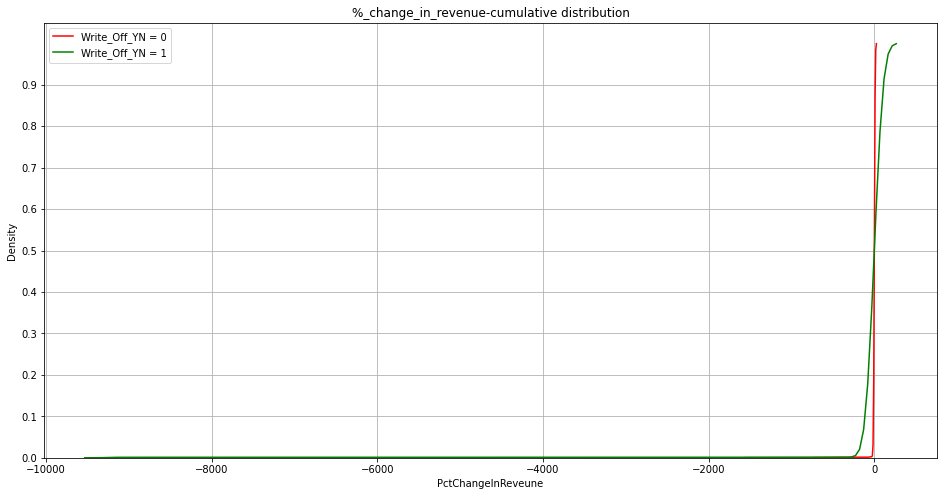

In [66]:
plt.figure(figsize = (16,8))

sns.kdeplot(data = data[data['WriteOff_YN']==0]['PctChangeInReveune'], cumulative = True, label = "Write_Off_YN = 0", color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['PctChangeInReveune'], cumulative = True, label = "Write_Off_YN = 1", color = 'green')

# plt.xticks(np.arange(0,20,2))
plt.yticks(np.arange(0,1,0.1))
plt.title('%_change_in_revenue-cumulative distribution')
plt.grid()
plt.legend()

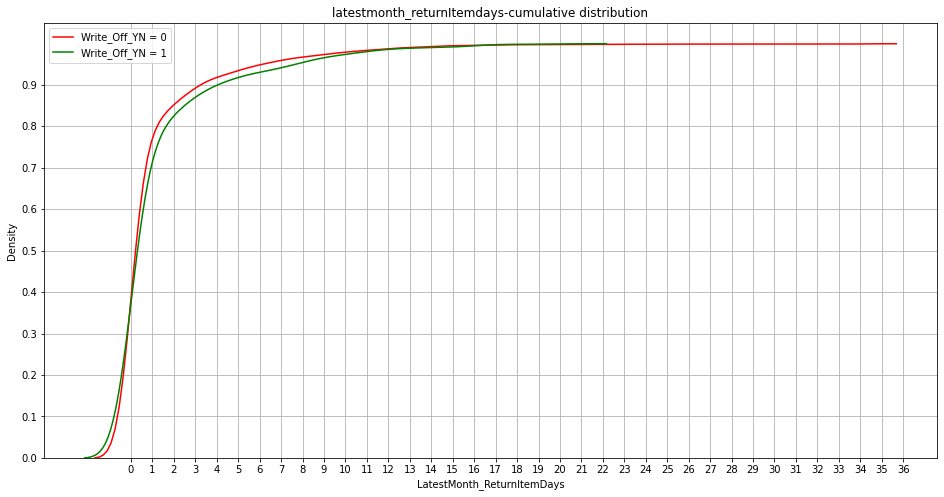

In [67]:
plt.figure(figsize = (16,8))

sns.kdeplot(data = data[data['WriteOff_YN']==0]['LatestMonth_ReturnItemDays'], cumulative = True, label = "Write_Off_YN = 0", color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['LatestMonth_ReturnItemDays'], cumulative = True, label = "Write_Off_YN = 1", color = 'green')

plt.xticks(np.arange(0,37,1))
plt.yticks(np.arange(0,1,0.1))
plt.title('latestmonth_returnItemdays-cumulative distribution')
plt.grid()
plt.legend()

In [68]:
f1_latestmonth_returnItemdays, f2_latestmonth_returnItemdays, f3_latestmonth_returnItemdays = [], [], []
for i in data["LatestMonth_ReturnItemDays"]:
  if i >= 1 and i <4:
    f1_latestmonth_returnItemdays.append(1)
    f2_latestmonth_returnItemdays.append(0)
    f3_latestmonth_returnItemdays.append(0)
  elif i >=4 and i <=8:
    f1_latestmonth_returnItemdays.append(0)
    f2_latestmonth_returnItemdays.append(1)
    f3_latestmonth_returnItemdays.append(0)
  else:
    f1_latestmonth_returnItemdays.append(0)
    f2_latestmonth_returnItemdays.append(0)
    f3_latestmonth_returnItemdays.append(1)

In [69]:
data["f1_latestmonth_returnItemdays"] = f1_latestmonth_returnItemdays
data["f2_latestmonth_returnItemdays"] = f2_latestmonth_returnItemdays
data["f3_latestmonth_returnItemdays"] = f3_latestmonth_returnItemdays

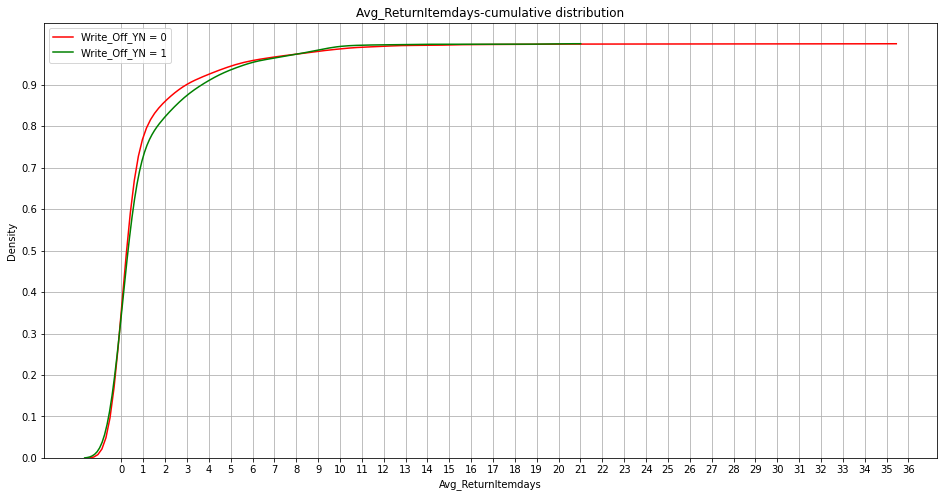

In [70]:
plt.figure(figsize = (16,8))

sns.kdeplot(data = data[data['WriteOff_YN']==0]['Avg_ReturnItemdays'], cumulative = True, label = "Write_Off_YN = 0", color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['Avg_ReturnItemdays'], cumulative = True, label = "Write_Off_YN = 1", color = 'green')

plt.xticks(np.arange(0,37,1))
plt.yticks(np.arange(0,1,0.1))
plt.title('Avg_ReturnItemdays-cumulative distribution')
plt.grid()
plt.legend()

In [71]:
f1_Avg_ReturnItemdays, f2_Avg_ReturnItemdays, f3_Avg_ReturnItemdays = [], [], []
for i in data["Avg_ReturnItemdays"]:
  if i >= 1 and i <3:
    f1_Avg_ReturnItemdays.append(1)
    f2_Avg_ReturnItemdays.append(0)
    f3_Avg_ReturnItemdays.append(0)
  elif i >=3 and i <=5:
    f1_Avg_ReturnItemdays.append(0)
    f2_Avg_ReturnItemdays.append(1)
    f3_Avg_ReturnItemdays.append(0)
  else:
    f1_Avg_ReturnItemdays.append(0)
    f2_Avg_ReturnItemdays.append(0)
    f3_Avg_ReturnItemdays.append(1)

In [72]:
data["f1_Avg_ReturnItemdays"] = f1_Avg_ReturnItemdays
data["f2_Avg_ReturnItemdays"] = f2_Avg_ReturnItemdays
data["f3_Avg_ReturnItemdays"] = f3_Avg_ReturnItemdays

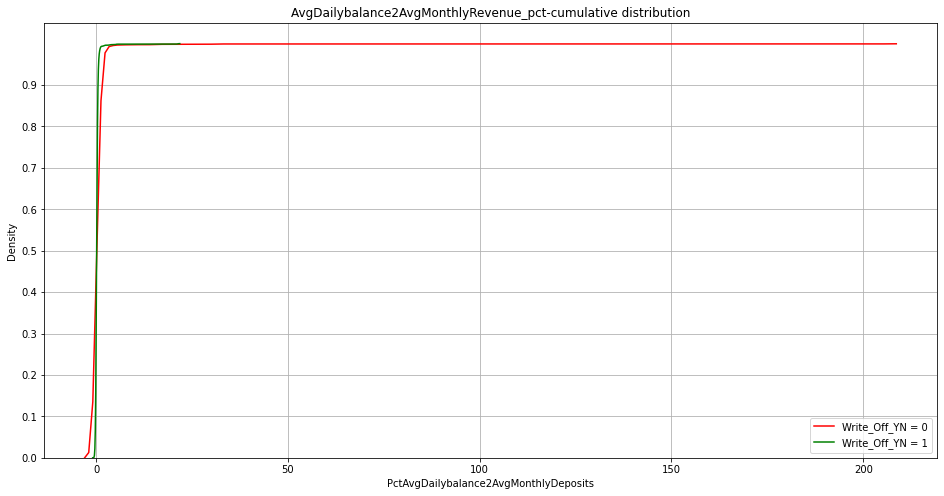

In [73]:
plt.figure(figsize = (16,8))

sns.kdeplot(data = data[data['WriteOff_YN']==0]['PctAvgDailybalance2AvgMonthlyDeposits'], cumulative = True, label = "Write_Off_YN = 0", color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['PctAvgDailybalance2AvgMonthlyDeposits'], cumulative = True, label = "Write_Off_YN = 1", color = 'green')

# plt.xticks(np.arange(0,37,1))
plt.yticks(np.arange(0,1,0.1))
plt.title('AvgDailybalance2AvgMonthlyRevenue_pct-cumulative distribution')
plt.grid()
plt.legend()

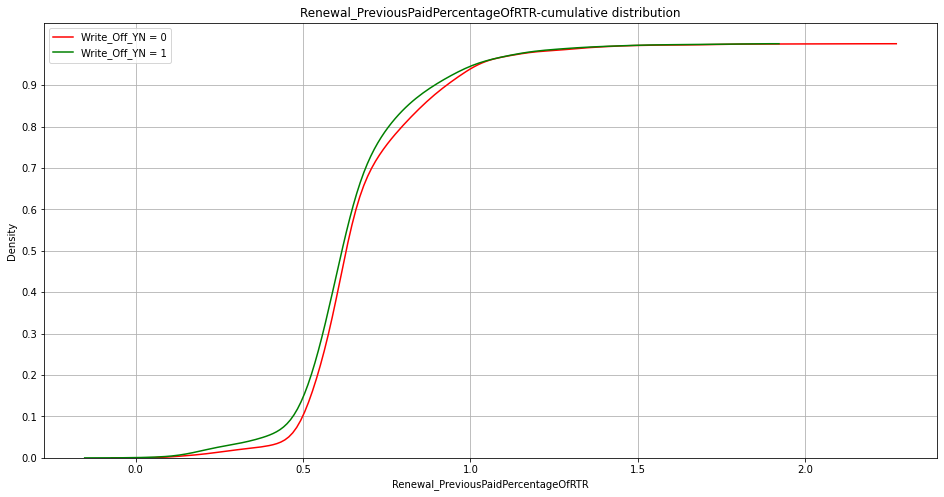

In [74]:
plt.figure(figsize = (16,8))

sns.kdeplot(data = data[data['WriteOff_YN']==0]['Renewal_PreviousPaidPercentageOfRTR'], cumulative = True, label = "Write_Off_YN = 0", color = 'red')
sns.kdeplot(data = data[data['WriteOff_YN']==1]['Renewal_PreviousPaidPercentageOfRTR'], cumulative = True, label = "Write_Off_YN = 1", color = 'green')

# plt.xticks(np.arange(0,37,1))
plt.yticks(np.arange(0,1,0.1))
plt.title('Renewal_PreviousPaidPercentageOfRTR-cumulative distribution')
plt.grid()
plt.legend()

In [75]:
f1_Renewal_PreviousPaidPercentageOfRTR, f2_Renewal_PreviousPaidPercentageOfRTR, f3_Renewal_PreviousPaidPercentageOfRTR = [], [], []
for i in data["Avg_ReturnItemdays"]:
  if i >= 0.0 and i <0.5:
    f1_Renewal_PreviousPaidPercentageOfRTR.append(1)
    f2_Renewal_PreviousPaidPercentageOfRTR.append(0)
    f3_Renewal_PreviousPaidPercentageOfRTR.append(0)
  elif i >=0.5 and i <=1.0:
    f1_Renewal_PreviousPaidPercentageOfRTR.append(0)
    f2_Renewal_PreviousPaidPercentageOfRTR.append(1)
    f3_Renewal_PreviousPaidPercentageOfRTR.append(0)
  else:
    f1_Renewal_PreviousPaidPercentageOfRTR.append(0)
    f2_Renewal_PreviousPaidPercentageOfRTR.append(0)
    f3_Renewal_PreviousPaidPercentageOfRTR.append(1)

In [76]:
data["f1_Renewal_PreviousPaidPercentageOfRTR"] = f1_Renewal_PreviousPaidPercentageOfRTR
data["f2_Renewal_PreviousPaidPercentageOfRTR"] = f2_Renewal_PreviousPaidPercentageOfRTR
data["f3_Renewal_PreviousPaidPercentageOfRTR"] = f3_Renewal_PreviousPaidPercentageOfRTR

In [77]:
data.shape

(3127, 56)

In [78]:
data.to_excel("/content/drive/MyDrive/LCF_Internal/Renewable_Model/EDA Approach-1/XGBoost Implementation/xgboost_v7/FE_v7.xlsx", index=False)

# New attributes

* FundedAmount
* Paybackamount
* WOGross_AdvanceBalance